### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.signal import find_peaks
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Import only the medium speed data
df = pd.read_csv('../Data/combined_data.csv')
df_med = df[df['speed'] == 1].copy()

In [3]:
# Divide the data into classes based on weight.
num_classes = 3
df_med.loc[:, 'weight_class'] = pd.qcut(df_med['weight'], q=num_classes, labels=False)

In [4]:
# Group the DataFrame by 'weight_class' and get unique 'weight' in each group
weights_by_class= df_med.groupby('weight_class')['weight'].unique()

weights_by_class

weight_class
0    [85.1, 86.7, 88.35, 89.4, 90.6, 91.95]
1           [93.35, 94.5, 95.0, 96.1, 97.6]
2       [98.85, 100.0, 101.6, 103.0, 104.5]
Name: weight, dtype: object

In [5]:
def train_test():
    # Split the data into training and testing sets
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    weights_by_class = df_med.groupby('weight_class')['weight'].unique()
    
    for weight_class, weights in weights_by_class.items():
        weights = sorted(weights)
        test_weights = [weights[1], weights[3]]  # Select the testing weights
        train_weights = [weight for i, weight in enumerate(weights) if i not in [1, 3]]  # Exclude the testing weights
        
        df_test = pd.concat([df_test, df_med[(df_med['weight_class'] == weight_class) & (df_med['weight'].isin(test_weights))]], ignore_index=True)
        for weight in train_weights:
            df_train = pd.concat([df_train, df_med[(df_med['weight_class'] == weight_class) & (df_med['weight'] == weight)]], ignore_index=True)
    
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    return df_train, df_test

### Extract features

In [6]:
# Feature extraction function
# Credit to: https://towardsdatascience.com/feature-engineering-on-time-series-data-transforming-signal-data-of-a-smartphone-accelerometer-for-72cbe34b8a60

def extract_features(df, window_size, step_size):
    ax_list, ay_list, az_list, labels = [], [], [], []
    for i in range(0, df.shape[0] - window_size, step_size):
        axs = df['gx'].values[i: i + window_size]
        ays = df['gy'].values[i: i + window_size]
        azs = df['gz'].values[i: i + window_size]
        label = df['weight_class'].iloc[i: i + window_size].mode()[0]
        
        ax_list.append(axs)
        ay_list.append(ays)
        az_list.append(azs)
        labels.append(label)
    
    X = pd.DataFrame()
    
    X['x_mean'] = pd.Series(ax_list).apply(lambda x: x.mean())
    X['y_mean'] = pd.Series(ay_list).apply(lambda x: x.mean())
    X['z_mean'] = pd.Series(az_list).apply(lambda x: x.mean())

    X['x_std'] = pd.Series(ax_list).apply(lambda x: x.std())
    X['y_std'] = pd.Series(ay_list).apply(lambda x: x.std())
    X['z_std'] = pd.Series(az_list).apply(lambda x: x.std())

    X['x_aad'] = pd.Series(ax_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X['y_aad'] = pd.Series(ay_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X['z_aad'] = pd.Series(az_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

    X['x_min'] = pd.Series(ax_list).apply(lambda x: x.min())
    X['y_min'] = pd.Series(ay_list).apply(lambda x: x.min())
    X['z_min'] = pd.Series(az_list).apply(lambda x: x.min())

    X['x_max'] = pd.Series(ax_list).apply(lambda x: x.max())
    X['y_max'] = pd.Series(ay_list).apply(lambda x: x.max())
    X['z_max'] = pd.Series(az_list).apply(lambda x: x.max())

    X['x_maxmin_diff'] = X['x_max'] - X['x_min']
    X['y_maxmin_diff'] = X['y_max'] - X['y_min']
    X['z_maxmin_diff'] = X['z_max'] - X['z_min']
    
    X['x_median'] = pd.Series(ax_list).apply(lambda x: np.median(x))
    X['y_median'] = pd.Series(ay_list).apply(lambda x: np.median(x))
    X['z_median'] = pd.Series(az_list).apply(lambda x: np.median(x))
    
    X['x_mad'] = pd.Series(ax_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X['y_mad'] = pd.Series(ay_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X['z_mad'] = pd.Series(az_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    
    X['x_IQR'] = pd.Series(ax_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X['y_IQR'] = pd.Series(ay_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X['z_IQR'] = pd.Series(az_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    
    X['x_neg_count'] = pd.Series(ax_list).apply(lambda x: np.sum(x < 0))
    X['y_neg_count'] = pd.Series(ay_list).apply(lambda x: np.sum(x < 0))
    X['z_neg_count'] = pd.Series(az_list).apply(lambda x: np.sum(x < 0))
    
    X['x_pos_count'] = pd.Series(ax_list).apply(lambda x: np.sum(x > 0))
    X['y_pos_count'] = pd.Series(ay_list).apply(lambda x: np.sum(x > 0))
    X['z_pos_count'] = pd.Series(az_list).apply(lambda x: np.sum(x > 0))
    
    X['x_above_mean'] = pd.Series(ax_list).apply(lambda x: np.sum(x > x.mean()))
    X['y_above_mean'] = pd.Series(ay_list).apply(lambda x: np.sum(x > x.mean()))
    X['z_above_mean'] = pd.Series(az_list).apply(lambda x: np.sum(x > x.mean()))
    
    X['x_peak_count'] = pd.Series(ax_list).apply(lambda x: len(find_peaks(x)[0]))
    X['y_peak_count'] = pd.Series(ay_list).apply(lambda x: len(find_peaks(x)[0]))
    X['z_peak_count'] = pd.Series(az_list).apply(lambda x: len(find_peaks(x)[0]))
    
    X['x_skewness'] = pd.Series(ax_list).apply(lambda x: stats.skew(x))
    X['y_skewness'] = pd.Series(ay_list).apply(lambda x: stats.skew(x))
    X['z_skewness'] = pd.Series(az_list).apply(lambda x: stats.skew(x))
    
    X['x_kurtosis'] = pd.Series(ax_list).apply(lambda x: stats.kurtosis(x))
    X['y_kurtosis'] = pd.Series(ay_list).apply(lambda x: stats.kurtosis(x))
    X['z_kurtosis'] = pd.Series(az_list).apply(lambda x: stats.kurtosis(x))
    
    X['x_energy'] = pd.Series(ax_list).apply(lambda x: np.sum(x**2)/100)
    X['y_energy'] = pd.Series(ay_list).apply(lambda x: np.sum(x**2)/100)
    X['z_energy'] = pd.Series(az_list).apply(lambda x: np.sum(x**2/100))
    
    X['avg_result_accl'] = [i.mean() for i in ((pd.Series(ax_list)**2 + pd.Series(ay_list)**2 + pd.Series(az_list)**2)**0.5)]
    X['sma'] = pd.Series(ax_list).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(ay_list).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(az_list).apply(lambda x: np.sum(abs(x)/100))
    
    # FFT features
    x_list_fft = pd.Series(ax_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
    y_list_fft = pd.Series(ay_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
    z_list_fft = pd.Series(az_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
    
    X['x_mean_fft'] = x_list_fft.apply(lambda x: x.mean())
    X['y_mean_fft'] = y_list_fft.apply(lambda x: x.mean())
    X['z_mean_fft'] = z_list_fft.apply(lambda x: x.mean())
    
    X['x_std_fft'] = x_list_fft.apply(lambda x: x.std())
    X['y_std_fft'] = y_list_fft.apply(lambda x: x.std())
    X['z_std_fft'] = z_list_fft.apply(lambda x: x.std())
    
    X['x_aad_fft'] = x_list_fft.apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X['y_aad_fft'] = y_list_fft.apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X['z_aad_fft'] = z_list_fft.apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    
    X['x_min_fft'] = x_list_fft.apply(lambda x: x.min())
    X['y_min_fft'] = y_list_fft.apply(lambda x: x.min())
    X['z_min_fft'] = z_list_fft.apply(lambda x: x.min())
    
    X['x_max_fft'] = x_list_fft.apply(lambda x: x.max())
    X['y_max_fft'] = y_list_fft.apply(lambda x: x.max())
    X['z_max_fft'] = z_list_fft.apply(lambda x: x.max())
    
    X['x_maxmin_diff_fft'] = X['x_max_fft'] - X['x_min_fft']
    X['y_maxmin_diff_fft'] = X['y_max_fft'] - X['y_min_fft']
    X['z_maxmin_diff_fft'] = X['z_max_fft'] - X['z_min_fft']
    
    X['x_median_fft'] = x_list_fft.apply(lambda x: np.median(x))
    X['y_median_fft'] = y_list_fft.apply(lambda x: np.median(x))
    X['z_median_fft'] = z_list_fft.apply(lambda x: np.median(x))
    
    X['x_mad_fft'] = x_list_fft.apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X['y_mad_fft'] = y_list_fft.apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X['z_mad_fft'] = z_list_fft.apply(lambda x: np.median(np.absolute(x - np.median(x))))
    
    X['x_IQR_fft'] = x_list_fft.apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X['y_IQR_fft'] = y_list_fft.apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X['z_IQR_fft'] = z_list_fft.apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    
    X['x_above_mean_fft'] = x_list_fft.apply(lambda x: np.sum(x > x.mean()))
    X['y_above_mean_fft'] = y_list_fft.apply(lambda x: np.sum(x > x.mean()))
    X['z_above_mean_fft'] = z_list_fft.apply(lambda x: np.sum(x > x.mean()))

    X['x_peak_count_fft'] = x_list_fft.apply(lambda x: len(find_peaks(x)[0]))
    X['y_peak_count_fft'] = y_list_fft.apply(lambda x: len(find_peaks(x)[0]))
    X['z_peak_count_fft'] = z_list_fft.apply(lambda x: len(find_peaks(x)[0]))

    X['x_skewness_fft'] = x_list_fft.apply(lambda x: stats.skew(x))
    X['y_skewness_fft'] = y_list_fft.apply(lambda x: stats.skew(x))
    X['z_skewness_fft'] = z_list_fft.apply(lambda x: stats.skew(x))
    
    X['x_kurtosis_fft'] = x_list_fft.apply(lambda x: stats.kurtosis(x))
    X['y_kurtosis_fft'] = y_list_fft.apply(lambda x: stats.kurtosis(x))
    X['z_kurtosis_fft'] = z_list_fft.apply(lambda x: stats.kurtosis(x))
    
    X['x_energy_fft'] = x_list_fft.apply(lambda x: np.sum(x**2)/50)
    X['y_energy_fft'] = y_list_fft.apply(lambda x: np.sum(x**2)/50)
    X['z_energy_fft'] = z_list_fft.apply(lambda x: np.sum(x**2)/50)
    
    X['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]
    
    X['sma_fft'] = x_list_fft.apply(lambda x: np.sum(abs(x)/50)) + y_list_fft.apply(lambda x: np.sum(abs(x)/50)) + z_list_fft.apply(lambda x: np.sum(abs(x)/50))

    # X['speed'] = df['speed']
    
    y = np.array(labels)
    return X, y


In [7]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.savefig(filename)
    plt.close()

In [8]:
def save_classification_report(y_true, y_pred, filename):
    report = classification_report(y_true, y_pred)
    with open(filename, 'w') as file:
        file.write(report)

In [9]:
# creating overlapping windows of size window-size 400 (200 hz * 2 seconds = 400 frame windows for 2 seconds)
window_size = 400
step_size = 200

In [10]:
output_dir = '../Results'
os.makedirs(output_dir, exist_ok=True)

### Models

#### All sensors

In [11]:
df_train, df_test = train_test()
X_train, y_train = extract_features(df_train, window_size, step_size)
X_test, y_test = extract_features(df_test, window_size, step_size)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
# KNN model
knn_model = KNeighborsClassifier(n_jobs=1) # Create KNN model
knn_model.fit(X_train, y_train) # Fit the model
y_pred_knn = knn_model.predict(X_test) # Make predictions

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Model:")
print("Accuracy:", accuracy_knn)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_knn))

# Save the results
# plot_confusion_matrix(y_test, y_pred_knn, 'KNN - All sensors', 'Results/Medium_speed/{0} classes/knn_all_sensors.png'.format(num_classes))
# save_classification_report(y_test, y_pred_knn, 'Results/Medium_speed/{0} classes/knn_all_sensors.txt'.format(num_classes))

# Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42) # Create Decision Tree model
dt_model.fit(X_train, y_train) # Fit the model
y_pred_dt = dt_model.predict(X_test) # Make predictions

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Model:")
print("Accuracy:", accuracy_dt)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_dt))

# Save the results
# plot_confusion_matrix(y_test, y_pred_dt, 'Decision Tree - All sensors', 'Results/Medium_speed/{0} classes/dt_all_sensors.png'.format(num_classes))
# save_classification_report(y_test, y_pred_dt, 'Results/Medium_speed/{0} classes/dt_all_sensors.txt'.format(num_classes))

# SVM model
svm_model = SVC(kernel='linear', C=1.0, random_state=42) # Create SVM model
svm_model.fit(X_train, y_train) # Fit the model
y_pred_svm = svm_model.predict(X_test) # Make predictions

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Model:")
print("Accuracy:", accuracy_svm)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_svm))

# Save the results
# plot_confusion_matrix(y_test, y_pred_svm, 'SVM - All sensors', 'Results/Medium_speed/{0} classes/svm_all_sensors.png'.format(num_classes))
# save_classification_report(y_test, y_pred_svm, 'Results/Medium_speed/{0} classes/svm_all_sensors.txt'.format(num_classes))

# Logistic Regression model
model_lr = LogisticRegression(max_iter=1000, random_state=42) # Create Logistic Regression model
model_lr.fit(X_train, y_train) # Fit the model
y_pred = model_lr.predict(X_test) # Make predictions

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred)
print("Logistic Regression Model:")
print("Accuracy:", accuracy_lr)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

# Save the results
# plot_confusion_matrix(y_test, y_pred, 'Logistic Regression - All sensors', 'Results/Medium_speed/{0} classes/lr_all_sensors.png'.format(num_classes))
# save_classification_report(y_test, y_pred, 'Results/Medium_speed/{0} classes/lr_all_sensors.txt'.format(num_classes))

KNN Model:
Accuracy: 0.4183030752130419

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.40      0.68      0.50      1800
           1       0.32      0.23      0.27      1800
           2       0.60      0.34      0.44      1798

    accuracy                           0.42      5398
   macro avg       0.44      0.42      0.40      5398
weighted avg       0.44      0.42      0.40      5398

Decision Tree Model:
Accuracy: 0.4271952575027788

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.41      0.53      0.47      1800
           1       0.35      0.32      0.33      1800
           2       0.54      0.43      0.48      1798

    accuracy                           0.43      5398
   macro avg       0.43      0.43      0.43      5398
weighted avg       0.43      0.43      0.43      5398

SVM Model:
Accuracy: 0.44627639866617264

 ---

#### Sensor 561 - On the head tube

In [13]:
df_train, df_test = train_test()
# Now only use the node-id 561
df_train = df_train[df_train['node-id'] == 561]
df_test = df_test[df_test['node-id'] == 561]
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
X_train, y_train = extract_features(df_train, window_size, step_size)
X_test, y_test = extract_features(df_test, window_size, step_size)
# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

KNN Model:
Accuracy: 0.38987764182424917

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.39      0.66      0.49       600
           1       0.30      0.24      0.27       600
           2       0.53      0.28      0.36       598

    accuracy                           0.39      1798
   macro avg       0.41      0.39      0.37      1798
weighted avg       0.41      0.39      0.37      1798



FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Uni\\MOD12 - Research Project\\Research_Project\\Results\\Medium_speed\\3 classes\\knn_sensor_561.png'

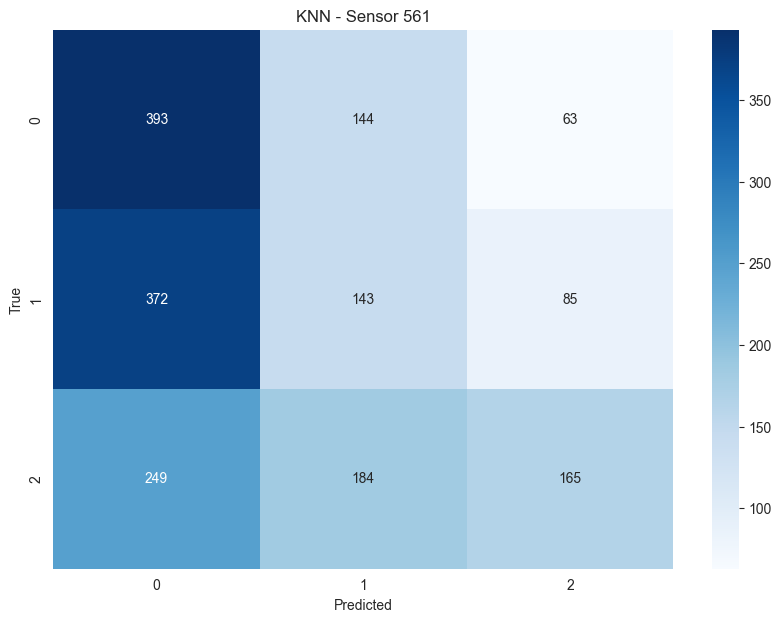

In [15]:
# KNN model
knn_model = KNeighborsClassifier(n_jobs=1) # Create KNN model
knn_model.fit(X_train, y_train) # Fit the model
y_pred_knn = knn_model.predict(X_test) # Make predictions

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Model:")
print("Accuracy:", accuracy_knn)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_knn))

# Save the results
plot_confusion_matrix(y_test, y_pred_knn, 'KNN - Sensor 561', 'Results/Medium_speed/{0} classes/knn_sensor_561.png'.format(num_classes))
save_classification_report(y_test, y_pred_knn, 'Results/Medium_speed/{0} classes/knn_sensor_561.txt'.format(num_classes))

# Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42) # Create Decision Tree model
dt_model.fit(X_train, y_train) # Fit the model
y_pred_dt = dt_model.predict(X_test) # Make predictions

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Model:")
print("Accuracy:", accuracy_dt)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_dt))

# Save the results
plot_confusion_matrix(y_test, y_pred_dt, 'Decision Tree - Sensor 561', 'Results/Medium_speed/{0} classes/dt_sensor_561.png'.format(num_classes))
save_classification_report(y_test, y_pred_dt, 'Results/Medium_speed/{0} classes/dt_sensor_561.txt'.format(num_classes))

# SVM model
svm_model = SVC(kernel='linear', C=1.0, random_state=42) # Create SVM model
svm_model.fit(X_train, y_train) # Fit the model
y_pred_svm = svm_model.predict(X_test) # Make predictions

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Model:")
print("Accuracy:", accuracy_svm)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_svm))

# Save the results
plot_confusion_matrix(y_test, y_pred_svm, 'SVM - Sensor 561', 'Results/Medium_speed/{0} classes/svm_sensor_561.png'.format(num_classes))
save_classification_report(y_test, y_pred_svm, 'Results/Medium_speed/{0} classes/svm_sensor_561.txt'.format(num_classes))

# Logistic Regression model
model_lr = LogisticRegression(max_iter=1000, random_state=42) # Create Logistic Regression model
model_lr.fit(X_train, y_train) # Fit the model
y_pred = model_lr.predict(X_test) # Make predictions

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred)
print("Logistic Regression Model:")
print("Accuracy:", accuracy_lr)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

# Save the results
plot_confusion_matrix(y_test, y_pred, 'Logistic Regression - Sensor 561', 'Results/Medium_speed/{0} classes/lr_sensor_561.png'.format(num_classes))
save_classification_report(y_test, y_pred, 'Results/Medium_speed/{0} classes/lr_sensor_561.txt'.format(num_classes))

#### Sensor 562 - Under the seat

In [ ]:
df_train, df_test = train_test()
# Now only use the node-id 562
df_train = df_train[df_train['node-id'] == 562]
df_test = df_test[df_test['node-id'] == 562]

In [ ]:
X_train, y_train = extract_features(df_train, window_size, step_size)
X_test, y_test = extract_features(df_test, window_size, step_size)
# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# KNN model
knn_model = KNeighborsClassifier(n_jobs=1) # Create KNN model
knn_model.fit(X_train, y_train) # Fit the model
y_pred_knn = knn_model.predict(X_test) # Make predictions

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Model:")
print("Accuracy:", accuracy_knn)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_knn))

# Save the results
# plot_confusion_matrix(y_test, y_pred_knn, 'KNN - Sensor 562', 'Results/Medium_speed/{0} classes/knn_sensor_562.png'.format(num_classes))
# save_classification_report(y_test, y_pred_knn, 'Results/Medium_speed/{0} classes/knn_sensor_562.txt'.format(num_classes))

# Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42) # Create Decision Tree model
dt_model.fit(X_train, y_train) # Fit the model
y_pred_dt = dt_model.predict(X_test) # Make predictions

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Model:")
print("Accuracy:", accuracy_dt)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_dt))

# Save the results
# plot_confusion_matrix(y_test, y_pred_dt, 'Decision Tree - Sensor 562', 'Results/Medium_speed/{0} classes/dt_sensor_562.png'.format(num_classes))
# save_classification_report(y_test, y_pred_dt, 'Results/Medium_speed/{0} classes/dt_sensor_562.txt'.format(num_classes))

# SVM model
svm_model = SVC(kernel='linear', C=1.0, random_state=42) # Create SVM model
svm_model.fit(X_train, y_train) # Fit the model
y_pred_svm = svm_model.predict(X_test) # Make predictions

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Model:")
print("Accuracy:", accuracy_svm)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_svm))

# Save the results
# plot_confusion_matrix(y_test, y_pred_svm, 'SVM - Sensor 562', 'Results/Medium_speed/{0} classes/svm_sensor_562.png'.format(num_classes))
# save_classification_report(y_test, y_pred_svm, 'Results/Medium_speed/{0} classes/svm_sensor_562.txt'.format(num_classes))

# Logistic Regression model
model_lr = LogisticRegression(max_iter=1000, random_state=42) # Create Logistic Regression model
model_lr.fit(X_train, y_train) # Fit the model
y_pred = model_lr.predict(X_test) # Make predictions

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred)
print("Logistic Regression Model:")
print("Accuracy:", accuracy_lr)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

# Save the results
# plot_confusion_matrix(y_test, y_pred, 'Logistic Regression - Sensor 562', 'Results/Medium_speed/{0} classes/lr_sensor_562.png'.format(num_classes))
# save_classification_report(y_test, y_pred, 'Results/Medium_speed/{0} classes/lr_sensor_562.txt'.format(num_classes))

#### Sensor 563 - Rear frame

In [ ]:
df_train, df_test = train_test()
# Now only use the node-id 563
df_train = df_train[df_train['node-id'] == 563]
df_test = df_test[df_test['node-id'] == 563]

In [ ]:
X_train, y_train = extract_features(df_train, window_size, step_size)
X_test, y_test = extract_features(df_test, window_size, step_size)
# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# KNN model
knn_model = KNeighborsClassifier(n_jobs=1) # Create KNN model
knn_model.fit(X_train, y_train) # Fit the model
y_pred_knn = knn_model.predict(X_test) # Make predictions

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Model:")
print("Accuracy:", accuracy_knn)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_knn))

# Save the results
plot_confusion_matrix(y_test, y_pred_knn, 'KNN - Sensor 563', 'Results/Medium_speed/{0} classes/knn_sensor_563.png'.format(num_classes))
save_classification_report(y_test, y_pred_knn, 'Results/Medium_speed/{0} classes/knn_sensor_563.txt'.format(num_classes))

# Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42) # Create Decision Tree model
dt_model.fit(X_train, y_train) # Fit the model
y_pred_dt = dt_model.predict(X_test) # Make predictions

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Model:")
print("Accuracy:", accuracy_dt)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_dt))

# Save the results
plot_confusion_matrix(y_test, y_pred_dt, 'Decision Tree - Sensor 563', 'Results/Medium_speed/{0} classes/dt_sensor_563.png'.format(num_classes))
save_classification_report(y_test, y_pred_dt, 'Results/Medium_speed/{0} classes/dt_sensor_563.txt'.format(num_classes))

# SVM model
svm_model = SVC(kernel='linear', C=1.0, random_state=42) # Create SVM model
svm_model.fit(X_train, y_train) # Fit the model
y_pred_svm = svm_model.predict(X_test) # Make predictions

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Model:")
print("Accuracy:", accuracy_svm)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_svm))

# Save the results
plot_confusion_matrix(y_test, y_pred_svm, 'SVM - Sensor 563', 'Results/Medium_speed/{0} classes/svm_sensor_563.png'.format(num_classes))
save_classification_report(y_test, y_pred_svm, 'Results/Medium_speed/{0} classes/svm_sensor_563.txt'.format(num_classes))

# Logistic Regression model
model_lr = LogisticRegression(max_iter=1000, random_state=42) # Create Logistic Regression model
model_lr.fit(X_train, y_train) # Fit the model
y_pred = model_lr.predict(X_test) # Make predictions

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred)
print("Logistic Regression Model:")
print("Accuracy:", accuracy_lr)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

# Save the results
plot_confusion_matrix(y_test, y_pred, 'Logistic Regression - Sensor 563', 'Results/Medium_speed/{0} classes/lr_sensor_563.png'.format(num_classes))
save_classification_report(y_test, y_pred, 'Results/Medium_speed/{0} classes/lr_sensor_563.txt'.format(num_classes))